# [CS 4476 Project 2: Local Feature Matching](https://www.cc.gatech.edu/~zlv30/courses/proj2.html)

This iPython notebook:  
(1) Loads and resizes images  
(2) Finds interest points in those images                 (you code this)  
(3) Describes each interest point with a local feature    (you code this)  
(4) Finds matching features                               (you code this)  
(5) Visualizes the matches  
(6) Evaluates the matches based on ground truth correspondences  

## Setup

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from student_feature_matching import match_features
from student_sift import get_features
from student_harris import get_interest_points
from IPython.core.debugger import set_trace

# Notre Dame
image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
#image1 = load_image('../data/Mount Rushmore/9021235130_7c2acd9554_o.jpg')
#image2 = load_image('../data/Mount Rushmore/9318872612_a255c874fb_o.jpg')
#eval_file = '../data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
#image1 = load_image('../data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg')
#image2 = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg')
#eval_file = '../data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'

                    
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

feature_width = 16 # width and height of each local feature, in pixels. 

## Find distinctive points in each image (Szeliski 4.1.1)

1356 corners in image 1, 1158 corners in image 2


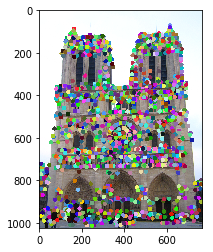

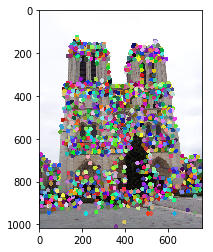

In [2]:
x1, y1, _, scales1, _ = get_interest_points(image1_bw, feature_width)
x2, y2, _, scales2, _ = get_interest_points(image2_bw, feature_width)
#x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
#plt.figure(); plt.imshow(image1_bw)

# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

## Create feature vectors at each interest point (Szeliski 4.1.2)

In [3]:
image1_features = get_features(image1_bw, x1, y1, feature_width, scales1)
image2_features = get_features(image2_bw, x2, y2, feature_width, scales2)

## Match features (Szeliski 4.1.3)

In [4]:
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

214 matches from 1356 corners


## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer.

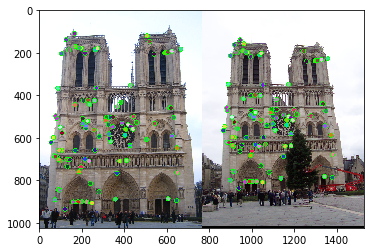

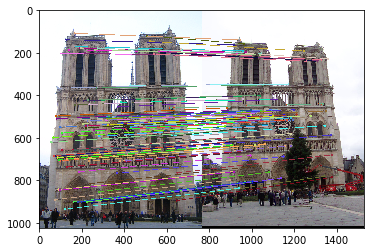

In [5]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.jpg', dpi=1000)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  
  
You can use `annotate_correspondences/collect_ground_truth_corr.py` to build the ground truth for other image pairs if you want, but it's very tedious. It would be a great service to the class for future years, though!

You found 100/100 required matches
Accuracy = 0.930000


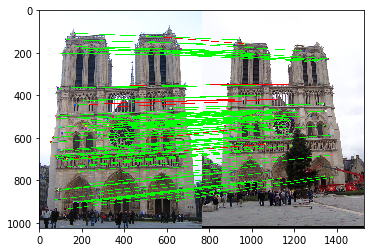

In [6]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.jpg', dpi=1000)

# Analysis


**1) Decribe implementation of your interest point detector ? Show the results of your interest point detector on two different images from the dataset.**

*Implementation of interest point detector:*

1. Calculate the gradient of an image `Ix, Iy` in `x` and `y` direction using Sobel operator `cv2.Sobel`
2. Calculate the second order derivative `Ix**2, Iy**2, Ix*Iy` and smooth out the output with Gaussian Filter `cv2.filter2D`
3. Arrive at the cornerness function `R = det(M) - alpha*trace(M)` with alpha = 0.07
4. Assign 0 to R values around the border of an image (zero-padding) and perform non-maximal supression with `scipy.ndimage.filters.maximum_filter` to find out the **interest points**
5. Sorted the (x,y) coordinates of the **interest points** based on the value of R in descending order with `np.unravel_index` and `np.argsort`.
6. Write the `adaptive` non-maximal supression function:
    + Loop over the sorted coordinates 
    + At each point (x,y) look for the nearest point with R(x_new,y_new) >0.9\*R(x,y). Calculate min_distance between these 2 points.
    + Sorted the (x, y) coordiantes based on this min_distance value in descending order
7. Return the `adaptive` non-maximal supression (x, y) coordiantes with maximum 1500 points

1500 corners in image 1, 1500 corners in image 2


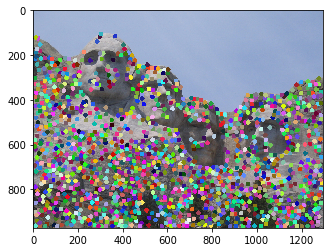

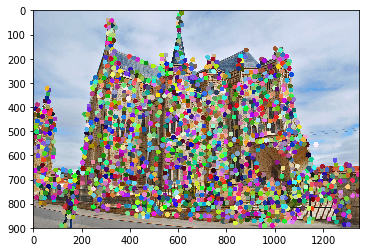

In [7]:
image1 = load_image('../data/Mount Rushmore/9021235130_7c2acd9554_o.jpg')
image2 = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg')
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

x1, y1, _, scales1, _ = get_interest_points(image1_bw, feature_width)
x2, y2, _, scales2, _ = get_interest_points(image2_bw, feature_width)

c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

***
**2) Describe how you implemented Adaptive non-maximum suppression ? Show the effectivness of ANMS on two different images from the dataset.**

*Add your description here*

Write the `adaptive` non-maximal supression function:

1. Loop over the sorted coordinates


2. At each point (x,y) look for the nearest point with R(x_new,y_new) >0.9\*R(x,y) if have:
    + define this threshold `corner_0p9 = 0.9*R[x,y]`
    + Calculate the distance from to all other points (x_new,y_new) to this point (x,y)
    + Only keep the distance where `R(x_new,y_new) >corner_0p9`
    + Find the `min_distance` where min_distance != 0
    
    
3. Sorted the (x, y) coordiantes based on this min_distance value in descending order

100 most confident corners from ANMS, 1500 corners with SIMPLE non-maximal supression


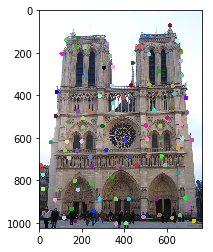

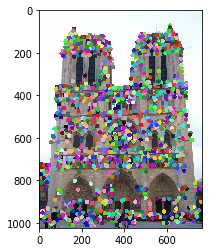

In [8]:
# Code for visualizing the impact of ANMS

# Notre Dame
image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
x1, y1, _, scales1, _ = get_interest_points(image1_bw, feature_width)

# Show the first 100 points (x,y) with largest distance to its 0.9*R(x,y)
c_ANMS = show_interest_points(image1, x1[:100], y1[:100])

# Full array is equivalent to simple non-maximal supression
c1 = show_interest_points(image1, x1, y1)
plt.figure(); plt.imshow(c_ANMS)
plt.figure(); plt.imshow(c1)
print('{:d} most confident corners from ANMS, {:d} corners with SIMPLE non-maximal supression'.format(len(x1[:100]), len(x2)))

***
**3) How you are creating SIFT descriptor? Please provide detailed description of your implementation.**

*Add your description here*

1. Calculate the gradient vector Ix, Iy using `cv2.Sobel`
2. At each interest points (x, y), find the 128-dimensional SIFT descriptor:
    + Divide the feature_width window into 4x4 smaller window
    + At each window, calculate the 8-bins histogram (4x4x8=128):
        + In each pixel, calculate the gradient Ix, Iy
        + Convert Ix, Iy to polar form (mag, phase)
        + Convert this (mag, phase) into `8-bins histogram` [0,45,90,135,180,225,270,325] of this pixel
        + Sum up 8-bins histogram of each pixel to the `8-bins histogram of the entire window`
    + Normalize the 128-dimensional SIFT descriptor as describled in the paper
3. Return the `normalized SIFT desciptor` of all the interest points 

***
**4) Provide details on your Feature matching pipline and ratio test? Show the result of your Feature matching pipeline on 'Notre Dam', 'Mount Rushmore' and 'Episcopal' image pairs.**

*Add your description here*

Feature matching algorithm:

1. Looping over the the feature1
    + At the `128-dimentional SIFT vector` of feature 1, calculate the distance of this vector to all other vectors in feature 2
    + Caculate the indexes of the `shortest distance` and `second shortest distance`
    + If the `shortest distance` < 0.8\*`second shortest distance`, then label a `matching_pairs` and this ratio of shortest/second shortest distance
2. Sorted the `matching_pairs` by the `ratio` in ascending order
3. Return the `matching_pairs` in the sorted order


In [9]:
def Visualize_matching_pairs(image1, image2, name, alpha = 0.1, top =1500):
    scale_factor = 0.5
    image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
    image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
    image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    x1, y1, _, scales1, _ = get_interest_points(image1_bw, feature_width, alpha = alpha, top =top)
    x2, y2, _, scales2, _ = get_interest_points(image2_bw, feature_width, alpha = alpha, top =top)

    image1_features = get_features(image1_bw, x1, y1, feature_width, scales1)
    image2_features = get_features(image2_bw, x2, y2, feature_width, scales2)

    matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
    print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

    num_pts_to_evaluate = 100
    _, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                            x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                            x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
    plt.figure(); plt.imshow(c)
    plt.savefig('../results/{}_eval.jpg'.format(name), dpi=1000)

214 matches from 1356 corners
You found 100/100 required matches
Accuracy = 0.930000


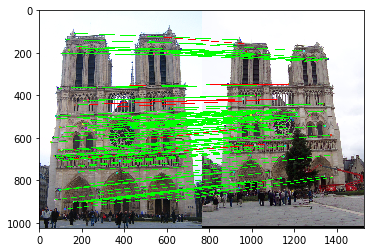

In [10]:
# Code for showing the results

# Notre Dame
image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

Visualize_matching_pairs(image1, image2, 'NotreDame')

179 matches from 1500 corners
You found 100/100 required matches
Accuracy = 0.930000


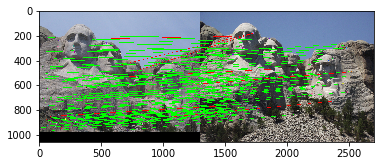

In [11]:
# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
image1 = load_image('../data/Mount Rushmore/9021235130_7c2acd9554_o.jpg')
image2 = load_image('../data/Mount Rushmore/9318872612_a255c874fb_o.jpg')
eval_file = '../data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'

Visualize_matching_pairs(image1, image2, 'MountRushmore')

8 matches from 628 corners
You found 8/100 required matches
Accuracy = 0.000000


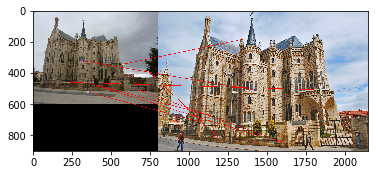

In [12]:
# # Episcopal Gaudi -- This pair is relatively difficult -- I think I need to implement the scale here
image1 = load_image('../data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg')
image2 = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg')
eval_file = '../data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'

Visualize_matching_pairs(image1, image2, 'EpiscopalGaudi')

***
**5) Detailed quantitative analysis showing the impact of two different hyperparameters on overall results? Describe how you tuned them? Illustrate using examples.**

*Add your description here*

Choose alpha for R function `R = det(M) - alpha*trace(M)`

In the previous code, I used `alpha = 0.1`, which achieves 0.93 accuracy. I illustrate 2 examples here when I choose `alpha = 0.05` and `alpha = 0`. Generally, the program works well with these hyperparameters, with accuracy is within the range 87-93%. Slight difference happens with the false matches highlighted in red.

Also, I can choose the cut-off for the number of points after the ANMS by tunning hyperparameters `top`. Compared to `top = 1500`, The number of matches for `top=600` significantly drop from aroung 200 to around 100. The accurary also drops to 70%. When `top=300`, I can only found 63 matches, and accuracy drops to 44%

#### Tuning `alpha` as hyperparameters for cornerness function

214 matches from 1356 corners
You found 100/100 required matches
Accuracy = 0.930000


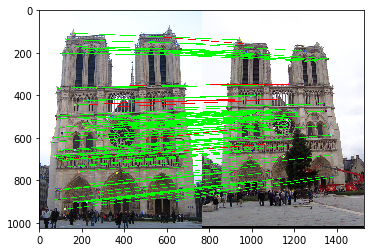

In [13]:
# Notre Dame
image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

Visualize_matching_pairs(image1, image2, 'NotreDame', alpha = 0.1)

221 matches from 1424 corners
You found 100/100 required matches
Accuracy = 0.870000


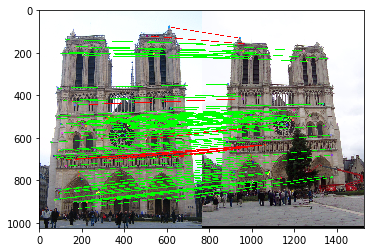

In [14]:
Visualize_matching_pairs(image1, image2, 'NotreDame', alpha = 0.05)

258 matches from 1500 corners
You found 100/100 required matches
Accuracy = 0.900000


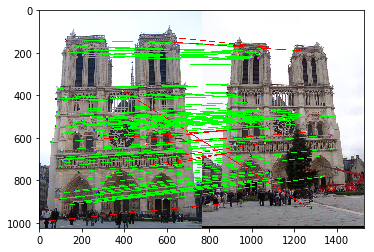

In [15]:
Visualize_matching_pairs(image1, image2, 'NotreDame', alpha = 0)

#### Tuning `top` as the numbers of corners I would like to extract from ANMS output

114 matches from 600 corners
You found 100/100 required matches
Accuracy = 0.700000


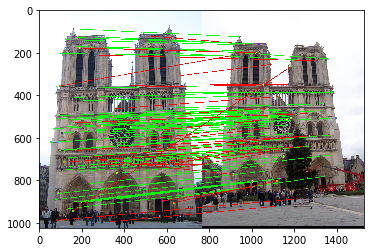

In [16]:
Visualize_matching_pairs(image1, image2, 'NotreDame', alpha = 0.1, top = 600)

63 matches from 300 corners
You found 63/100 required matches
Accuracy = 0.440000


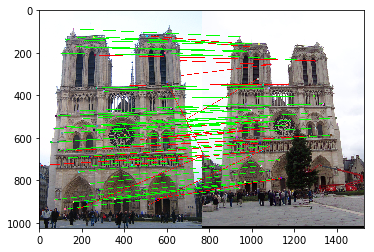

In [17]:
Visualize_matching_pairs(image1, image2, 'NotreDame', alpha = 0.1, top = 300)

****
# Extra Credit:- Bells and Whistles (Optional)

Implementation of bells and whistles can increase your grade by up to 10 points (potentially over 100). The max score for all students is 110.

For all extra credit, be sure to include quantitative analysis showing the impact of the particular method you've implemented. Each item is "up to" some amount of points because trivial implementations may not be worthy of full extra credit

### Interest point detection bells and whistles:

+ up to 7 pts: Try detecting keypoints at multiple scales or using a scale selection method to pick the best scale.
+ up to 7 pts: Try estimating the orientation of keypoints to make your local features rotation invariant.

### Local feature description bells and whistles:

+ up to 5 pts: The simplest thing to do is to experiment with the numerous SIFT parameters: how big should each feature be? How many local cells should it have? How many orientations should each histogram have? Different normalization schemes can have a significant effect, as well. Don't get lost in parameter tuning, though.
+ up to 7 pts: If your keypoint detector can estimate orientation, your local feature descriptor should be built accordingly so that your pipeline is rotation invariant.


### Local feature matching bells and whistles: 

An issue with the baseline matching algorithm is the computational expense of computing distance between all pairs of features. For a reasonable implementation of the base pipeline, this is likely to be the slowest part of the code. There are numerous schemes to try and approximate or accelerate feature matching: 

+ up to 10 pts: Use a space partitioning data structure like a kd-tree or some third party approximate nearest neighbor package to accelerate matching.

### Extra Credit  1 (Optional):- Local feature matching bells and whistles: 


*Provide short discription of your implementation here*

I implement 3 different local feature matching algorithms.
1. Naive for loop implementation.
2. Current impementation with numpy broadcasting distance matrix
3. Distance matrix calculated by `scipy.spatial.distance.cdist` with `metric='euclidean'` and `metric='cosine'`

In [18]:
# Load images
import time

from student_feature_matching import match_features_NAIVE
from student_feature_matching import match_features_SCIPY


image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

x1, y1, _, scales1, _ = get_interest_points(image1_bw, feature_width, alpha = 0.1, top =1500)
x2, y2, _, scales2, _ = get_interest_points(image2_bw, feature_width, alpha = 0.1, top =1500)

image1_features = get_features(image1_bw, x1, y1, feature_width, scales1)
image2_features = get_features(image2_bw, x2, y2, feature_width, scales2)


def feature_matching_timing(function, name, metric='euclidean'):
    print('---------------------------')
    print(name)
    start = time.time()
    matches, confidences = function(image1_features, image2_features, x1, y1, x2, y2, metric = metric)
    print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
    end = time.time()
    print('Timing elapse for %s: %.2f (s)' %(name, end - start))
    
    print('---------------------------')
    num_pts_to_evaluate = 100
    _, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                            x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                            x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
    plt.figure(); plt.imshow(c)

---------------------------
Naive For Loop
214 matches from 1356 corners
Timing elapse for Naive For Loop: 6.36 (s)
---------------------------
You found 100/100 required matches
Accuracy = 0.930000


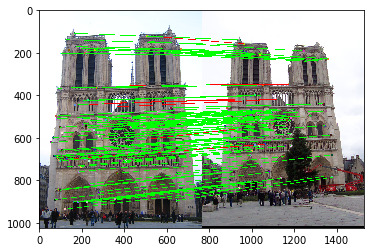

In [19]:
feature_matching_timing(match_features_NAIVE, 'Naive For Loop')

---------------------------
Numpy Array Broadcasting
214 matches from 1356 corners
Timing elapse for Numpy Array Broadcasting: 1.58 (s)
---------------------------
You found 100/100 required matches
Accuracy = 0.930000


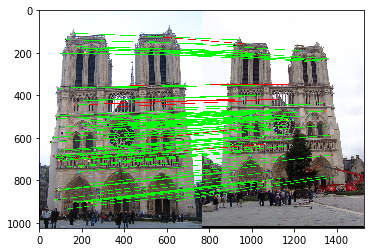

In [20]:
feature_matching_timing(match_features, 'Numpy Array Broadcasting')

---------------------------
SCIPY euclidean
214 matches from 1356 corners
Timing elapse for SCIPY euclidean: 0.32 (s)
---------------------------
You found 100/100 required matches
Accuracy = 0.930000


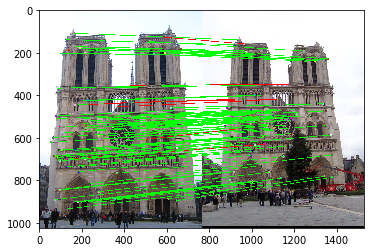

In [21]:
feature_matching_timing(match_features_SCIPY, 'SCIPY euclidean',metric='euclidean')

---------------------------
SCIPY cosine
433 matches from 1356 corners
Timing elapse for SCIPY cosine: 0.52 (s)
---------------------------
You found 100/100 required matches
Accuracy = 0.930000


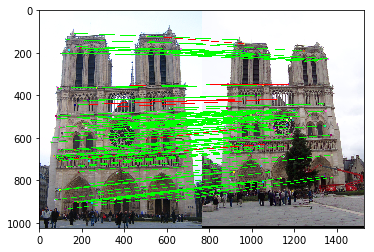

In [22]:
feature_matching_timing(match_features_SCIPY, 'SCIPY cosine',metric='cosine')

*Provide quantitative analysis showing the impact of the particular method or hyperparameter.*

Generally, all the techniques results in similar accuracy. `Python Loop` has slowest computation time in around 6-7(s), `numpy array` has moderate computation time of around 1-2(s). `Scipy cdist` is the fastest, with <0.5s. 

The distance metric can be either `euclidean` or `cosine`. Both yields the same accuracy, wher distance `cosine` find more matches, given the same `ratio = 0.8`.

****

### Extra Credit  2 (Optional):- Local feature description bells and whistles



*Provide short discription of your implementation here*

Sweeping the value of `feature_width` to check on the value of `accuracy` and `computation time`

In [23]:
# Code for Extra Credit 1


image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

def sweeping_feature_width(feature_width = 16):

    x1, y1, _, scales1, _ = get_interest_points(image1_bw, feature_width)
    x2, y2, _, scales2, _ = get_interest_points(image2_bw, feature_width)
    
    
    start = time.time()

    image1_features = get_features(image1_bw, x1, y1, feature_width, scales1)
    image2_features = get_features(image2_bw, x2, y2, feature_width, scales2)

    matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
    print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

    num_pts_to_evaluate = 100
    _, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                            x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                            x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
    plt.figure(); plt.imshow(c)
    
    end = time.time()
    print('Timing elapse: %.2f (s)' %(end - start))

187 matches from 1362 corners
You found 100/100 required matches
Accuracy = 0.680000
Timing elapse: 4.28 (s)


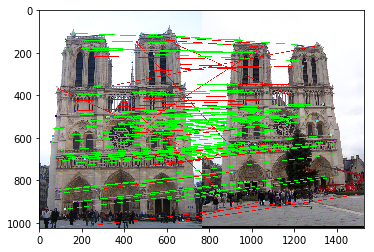

In [24]:
sweeping_feature_width(feature_width = 8)

214 matches from 1356 corners
You found 100/100 required matches
Accuracy = 0.930000
Timing elapse: 11.22 (s)


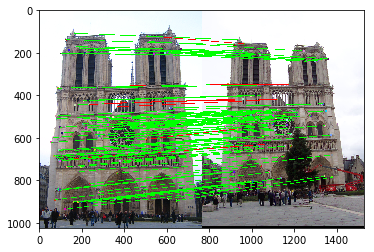

In [25]:
sweeping_feature_width(feature_width = 16)

264 matches from 1335 corners
You found 100/100 required matches
Accuracy = 0.910000
Timing elapse: 37.68 (s)


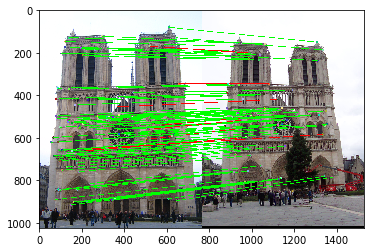

In [26]:
sweeping_feature_width(feature_width = 32)

254 matches from 1293 corners
You found 100/100 required matches
Accuracy = 0.940000
Timing elapse: 141.29 (s)


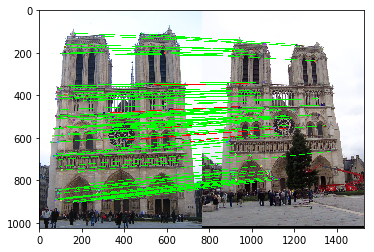

In [27]:
sweeping_feature_width(feature_width = 64)

In [28]:
# Show Results of your implementation

*Provide quantitative analysis showing the impact of the particular method or hyperparameter.*

We sweep the `feature_width` in `[8,16,32,64]`. 
+ So far, `feature_width = 16, 32,64` achieves similar accuracy, and substaintially better than `feature_width=8`. 
+ Computation time for `feature_width = 16` is much faster than those for `32, 64`. (11ms compared to 37ms/141ms)